# VAE on HSC images

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import torch
from datasets import load_from_disk

from galgenai import VAE, get_device, get_device_name


device = get_device()
print(f"Using device: {get_device_name()}")

Using device: cuda


## Load and inspect data

In [2]:
# dataset_raw = load_from_disk("../data/hsc_mmu_mini/")
dataset_raw = load_from_disk("/data/a/cpac/fkeruzore/hsc_mmu/")
dataset_raw = dataset_raw.select_columns(["image"]).with_format("torch")

n_gals = len(dataset_raw)
bands = dataset_raw[0]["image"]["band"]

# dataset.set_transform(lambda data: {"flux": data["image"]["flux"]})
# dataset = dataset.map(lambda x: {"flux": x["image"]["flux"]}, remove_columns=["image"])

# min/max
mins = torch.Tensor(-2 * np.ones(len(bands)))
maxs = torch.Tensor(99 * np.ones(len(bands)))


class FluxDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        hf_dataset,
        nx: int,
        mins: torch.TensorType,
        maxs: torch.TensorType,
    ):
        self.dataset = hf_dataset

        # crop to 128
        self.og_nx2 = self.dataset[0]["image"]["flux"].shape[1] // 2
        self.og_ny2 = self.dataset[0]["image"]["flux"].shape[2] // 2
        self.nx2 = nx // 2

        # norms
        self.mins = mins[:, None, None]
        self.maxs = maxs[:, None, None]

    def __len__(self):
        return len(self.dataset)

    def normalize(self, img):
        return (img - self.mins) / (self.maxs - self.mins)

    def crop(self, img):
        return img[
            :,
            self.og_nx2 - self.nx2 : self.og_nx2 + self.nx2,
            self.og_ny2 - self.nx2 : self.og_ny2 + self.nx2,
        ]

    def __getitem__(self, idx):
        image_data = self.dataset[idx]["image"]

        # Extract and crop flux
        flux = self.crop(image_data["flux"])
        # flux_normalized = self.normalize(flux)
        flux_normalized = flux

        # Extract and crop inverse variance
        ivar = self.crop(image_data["ivar"])
        # ivar_normalized = self.normalize(ivar**(-0.5)) ** (-2)
        ivar_normalized = ivar

        # Extract and crop mask
        mask = self.crop(image_data["mask"])

        return flux_normalized, ivar_normalized, mask


dataset = FluxDataset(dataset_raw, nx=64, mins=mins, maxs=maxs)
n_bands, n_x, n_y = dataset[0][0].shape  # First element of tuple is flux
assert n_x == n_y
assert len(bands) == n_bands
print(f"Images dimension: {n_bands}*{n_x}*{n_y} ({n_gals} galaxies)")

Images dimension: 5*64*64 (86614 galaxies)


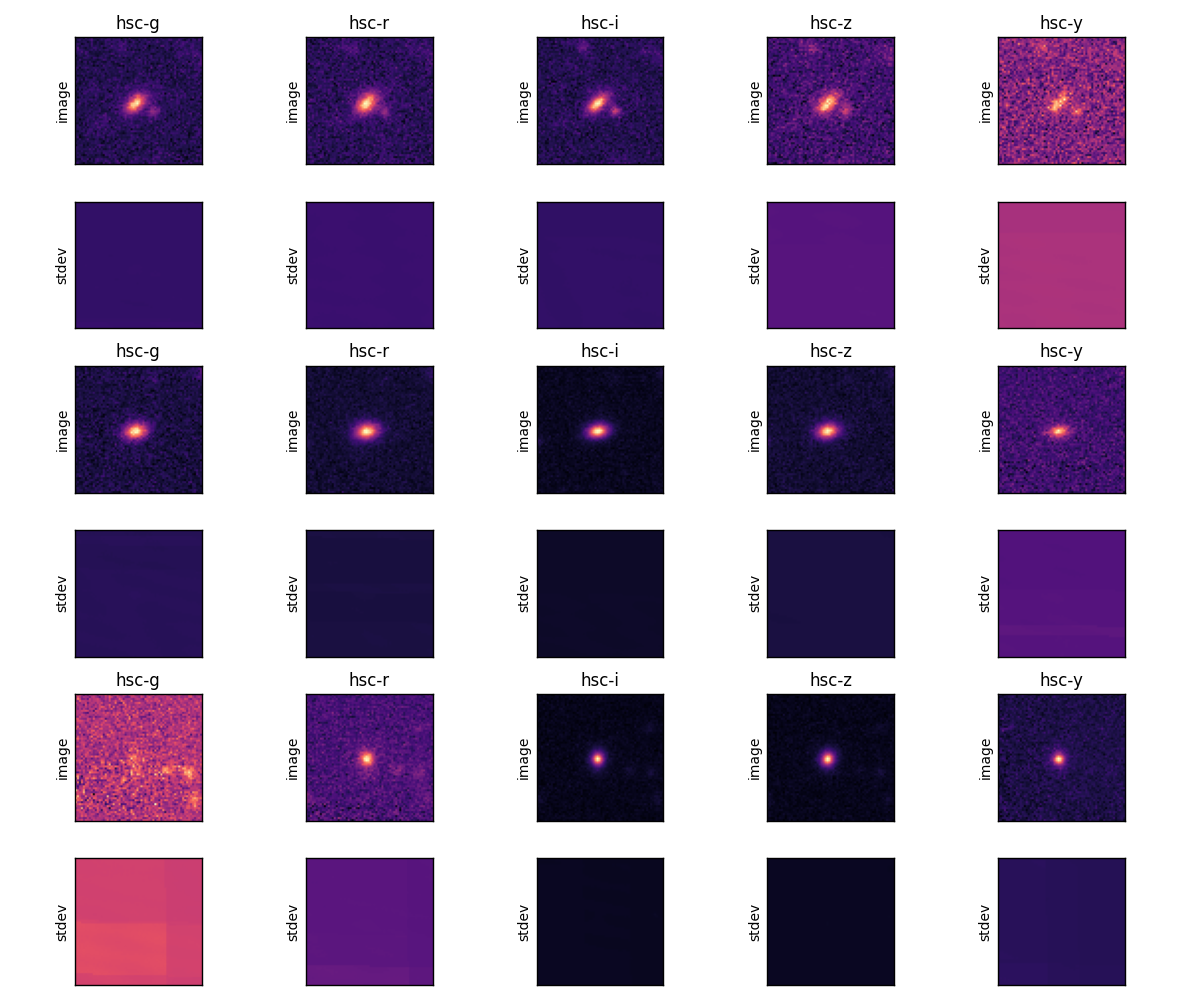

In [3]:
_n_plot = 3
fig, axs = plt.subplots(2 * _n_plot, n_bands, figsize=(12, 10))
cmap = plt.get_cmap("magma")
cmap.set_bad("0.5")

imgs = torch.stack([torch.stack(dataset[i]) for i in range(4)]).to(device)

for i in range(_n_plot):
    img, ivr, msk = imgs[i].cpu()
    ivr = ivr**-0.5
    for j, band in enumerate(bands):
        vmin, vmax = img[j].min(), img[j].max()
        axs[2 * i + 0, j].imshow(
            img[j] / msk[j], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax
        )
        axs[2 * i + 1, j].imshow(
            ivr[j] / msk[j], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax
        )
        axs[2 * i + 0, j].set_title(band)
        axs[2 * i + 0, j].set_ylabel("image")
        axs[2 * i + 1, j].set_ylabel("stdev")


for ax in axs.flatten():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
fig.tight_layout()

## Define model

In [4]:
model = VAE(in_channels=n_bands, latent_dim=32, input_size=n_x).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

Model parameters: 29,731,525


In [5]:
x = torch.randn(4, n_bands, n_x, n_y).to(device)  # batch
print(f"Input shape: {x.shape}")

reconstruction, mu, logvar = model(x)
print(f"Reconstruction shape: {reconstruction.shape}")
print(f"Latent mean shape: {mu.shape}")
print(f"Latent log variance shape: {logvar.shape}")

Input shape: torch.Size([4, 5, 64, 64])
Reconstruction shape: torch.Size([4, 5, 64, 64])
Latent mean shape: torch.Size([4, 32])
Latent log variance shape: torch.Size([4, 32])


## Check pre-training outputs

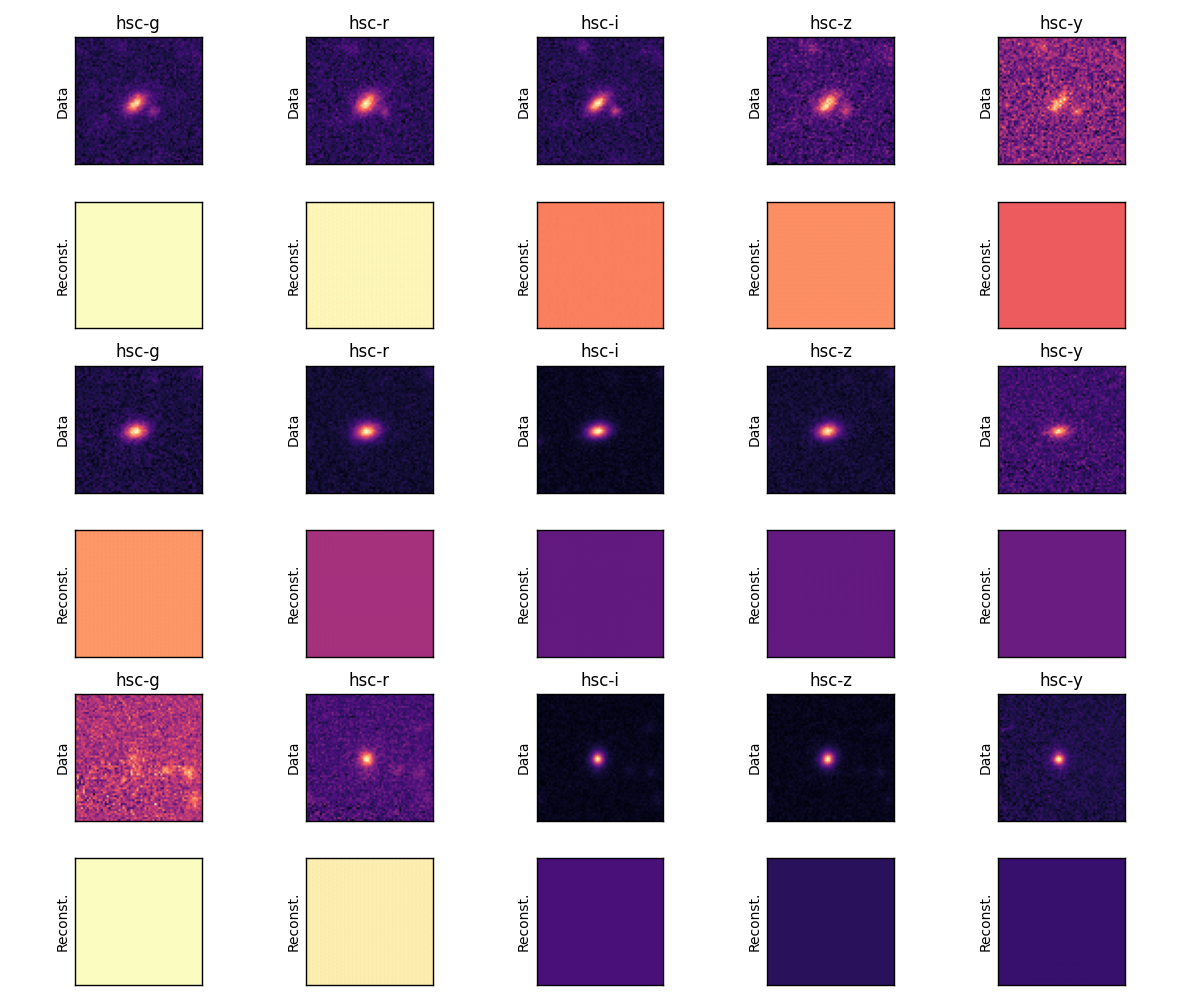

In [6]:
model.eval()

_n_plot = 3
fig, axs = plt.subplots(2 * _n_plot, n_bands, figsize=(12, 10))
cmap = plt.get_cmap("magma")
cmap.set_bad("0.5")

imgs = torch.stack([torch.stack(dataset[i]) for i in range(_n_plot)]).to(
    device
)
with torch.no_grad():
    recs, _, _ = model(imgs[:, 0, :, :, :].to(device))

for i in range(_n_plot):
    img, ivr, msk = imgs[i].cpu()
    rec = recs[i].cpu()
    for j, band in enumerate(bands):
        vmin, vmax = img[j].min(), img[j].max()
        axs[2 * i + 0, j].imshow(
            img[j] / msk[j], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax
        )
        axs[2 * i + 1, j].imshow(
            rec[j] / msk[j], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax
        )
        axs[2 * i + 0, j].set_title(band)
        axs[2 * i + 0, j].set_ylabel("Data")
        axs[2 * i + 1, j].set_ylabel("Reconst.")


for ax in axs.flatten():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
fig.tight_layout()

## Train

In [ ]:
from torch.utils.data import DataLoader, random_split
from galgenai.training import VAETrainer, VAETrainingConfig
import random

BATCH_SIZE = 128
NUM_WORKERS = 8
NUM_EPOCHS = 10

print(
    f"BATCH DIMENSION: {BATCH_SIZE * n_bands * n_x * n_x:.2e};",
    f"# NITS: {BATCH_SIZE * model.encoder.latent_dim:.2e}",
)

In [ ]:
torch.random.manual_seed(42)
np.random.seed(42)
random.seed(42)

dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
test_loader = DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

# Warm up (no KL)
config_warmup = VAETrainingConfig(
    num_epochs=1,
    learning_rate=1e-2,
    reconstruction_loss_fn="masked_weighted_mse",
    beta=0.0,
    max_grad_norm=2.0,
    output_dir="./vae_hsc_output",
    save_every=1000,
)
trainer = VAETrainer(
    model=model, train_loader=train_loader, config=config_warmup
)
trainer.train()

# Train with increasing beta
for lr, epochs, beta in [(1e-3, 4, 0.0), (5e-4, 5, 0.5), (5e-4, 6, 1.0)]:
    config = VAETrainingConfig(
        num_epochs=epochs,
        learning_rate=lr,
        reconstruction_loss_fn="masked_weighted_mse",
        beta=beta,
        max_grad_norm=2.0,
        output_dir="./vae_hsc_output",
        save_every=1000,
    )
    trainer = VAETrainer(model=model, train_loader=train_loader, config=config)
    trainer.train()

In [ ]:
config = VAETrainingConfig(
    num_epochs=16,
    learning_rate=5e-4,
    reconstruction_loss_fn="masked_weighted_mse",
    beta=1.0,
    max_grad_norm=2.0,
    output_dir="./vae_hsc_output",
    save_every=1000,
)
trainer = VAETrainer(model=model, train_loader=train_loader, config=config)
trainer.train()

## Check post-training outputs

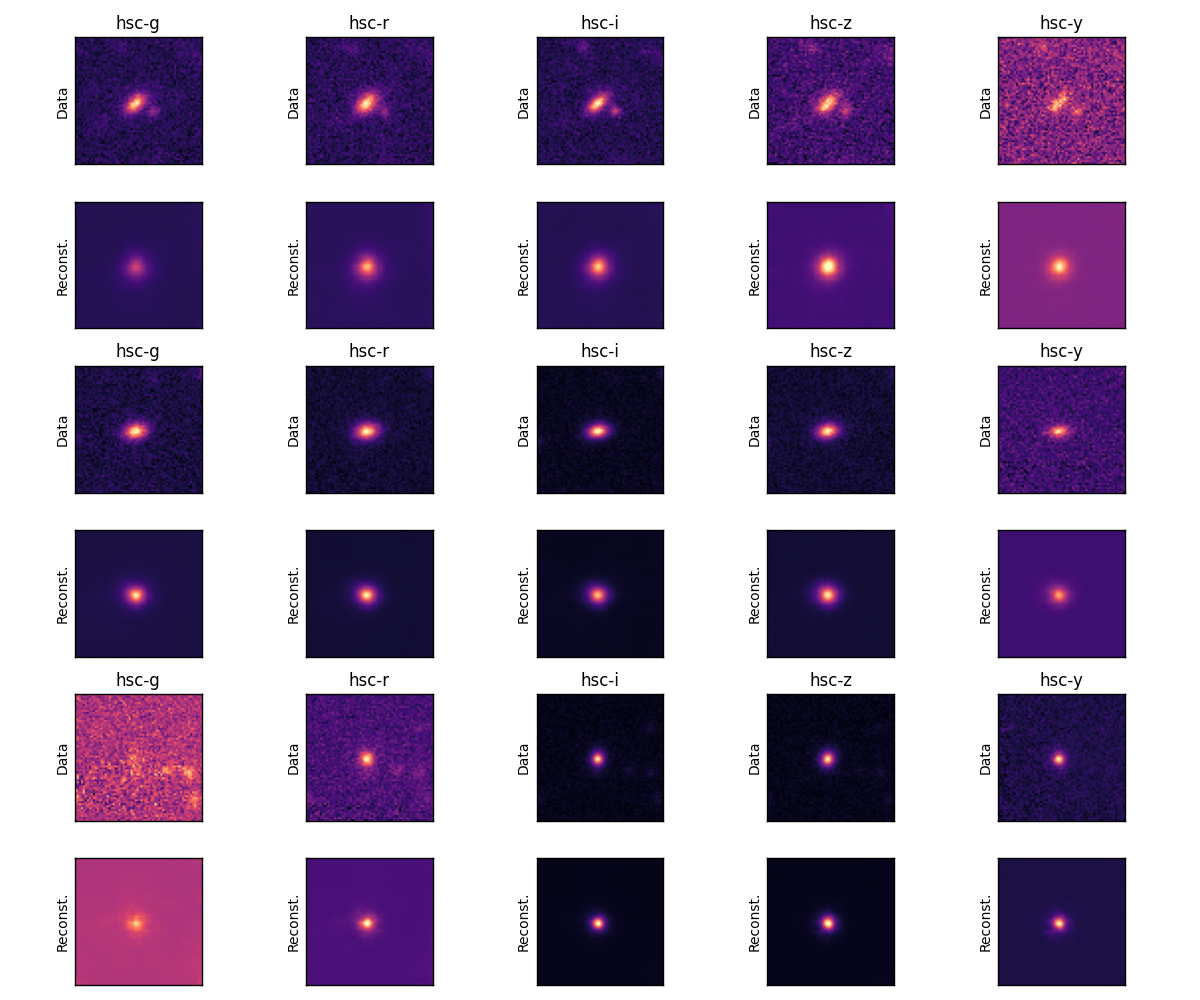

In [11]:
model.eval()

_n_plot = 3
fig, axs = plt.subplots(2 * _n_plot, n_bands, figsize=(12, 10))
cmap = plt.get_cmap("magma")
cmap.set_bad("0.5")

imgs = torch.stack([torch.stack(dataset[i]) for i in range(_n_plot)]).to(
    device
)
with torch.no_grad():
    recs, _, _ = model(imgs[:, 0, :, :, :].to(device))

for i in range(_n_plot):
    img, ivr, msk = imgs[i].cpu()
    rec = recs[i].cpu()
    for j, band in enumerate(bands):
        vmin, vmax = img[j].min(), img[j].max()
        axs[2 * i + 0, j].imshow(
            img[j] / msk[j], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax
        )
        axs[2 * i + 1, j].imshow(
            rec[j] / msk[j], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax
        )
        axs[2 * i + 0, j].set_title(band)
        axs[2 * i + 0, j].set_ylabel("Data")
        axs[2 * i + 1, j].set_ylabel("Reconst.")


for ax in axs.flatten():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
fig.tight_layout()